In [ ]:
!wget "https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz"

--2019-06-29 07:14:29--  https://cdn.rcsb.org/etl/kabschSander/ss.txt.gz
Resolving cdn.rcsb.org (cdn.rcsb.org)... 132.249.213.72
Connecting to cdn.rcsb.org (cdn.rcsb.org)|132.249.213.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41294075 (39M) [application/x-gzip]
Saving to: ‘ss.txt.gz’

ss.txt.gz           100%[===================>]  39.38M   372KB/s    in 1m 59s  

2019-06-29 07:16:29 (339 KB/s) - ‘ss.txt.gz’ saved [41294075/41294075]



In [ ]:
!gunzip ss.txt.gz

In [ ]:
import gzip
import logging
import csv
import argparse

with open('ss.txt', 'rt') as inf:
    # cannot use SeqIO.parse from Biopython because it cannot handle empty
    # string in DSSP secondary structure properly! Just put here for
    # reference

    # e.g. seqio = SeqIO.parse(inf, format='fasta')

    with open('out.csv', 'wt') as opf:
        csv_writer = csv.writer(opf)
        csv_writer.writerow(['pdb_id', 'chain_code', 'seq', 'sst'])

        state = None
        count = 0
        seq_id, seq_chain_id = '', ''
        sst_id, sst_chain_id = '', ''
        seq, sst = '', ''
        log_interval = 30000
        for k, line in enumerate(inf):
            if line.startswith('>'):
                line = line.replace('>', '')
                if state is None or state == 'ss':
                    if state == 'ss':
                        assert seq_id == sst_id
                        assert seq_chain_id == sst_chain_id
                        csv_writer.writerow(
                            [seq_id, seq_chain_id, seq, sst]
                        )
                        count += 1
                        if count % log_interval == 0:
                            msg = 'processing {0}th record'.format(count)
                            logging.info(msg)

                    state = 'seq'
                    seq_id = line.split(':')[0]
                    seq_chain_id = line.split(':')[1]
                    seq, sst = '', ''
                elif state == 'seq':
                    state = 'ss'
                    sst_id = line.split(':')[0]
                    sst_chain_id = line.split(':')[1]
                else:
                    raise ValueError('unknown state: {0}'.format(state))
                continue

            if state == 'seq':
                seq += line.strip()
            else:
                sst += line.replace(' ', 'C').strip()

        # count last seq
        count += 1

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("out.csv")
data.head()

,pdb_id,chain_code,seq,sst
0,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
1,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEEEESSSCTTTHHHHH...
2,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...
3,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,CCHHHHHHHHHCCEEEEEECTTSCEEEETTEECCCCCCCCCHHHHH...
4,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,CCCCHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHCGGGGGGCTT...


In [ ]:
import datetime
import itertools
import pandas as pd


In [ ]:
STATE_DD_8T3 = {
    'G': 'H',
    'H': 'H',
    'I': 'H',
    
    'B': 'E',
    'E': 'E',
    
    'T': 'C',
    'S': 'C',
    'C': 'C',
}

In [ ]:
STANDARD_AAS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
NON_STANDARD_AAS = list('BJOUXZ')

def mask_unk_aa(seq):
    for i in NON_STANDARD_AAS:
        seq = seq.replace(i, '*')
    return seq
  
def convert_8t3_state(sst):
    out = sst
    for i, j in STATE_DD_8T3.items():
        out = out.replace(i, j)
    return out
  


In [ ]:
adf = pd.read_csv('out.csv')
%time all_chars = set(itertools.chain(*adf.seq.values))
all_chars - set(STANDARD_AAS)
set(STANDARD_AAS) - all_chars
%time adf['seq'] = adf.seq.apply(mask_unk_aa).to_frame()
assert set(itertools.chain(*adf.seq.values)) - set(STANDARD_AAS) == set(['*'])
adf.rename(columns={'sst': 'sst8'}, inplace=True)

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s
CPU times: user 614 ms, sys: 2.38 ms, total: 617 ms
Wall time: 619 ms


In [ ]:
%time adf['sst3'] = adf['sst8'].apply(convert_8t3_state)
%time adf['len'] = adf.seq.apply(lambda s: len(s))
adf.head(1).T
adf.sort_values(['len', 'pdb_id', 'chain_code'], inplace=True)
%time adf['has_nonstd_aa'] = adf.seq.apply(lambda s: '*' in s)
adf.head()

CPU times: user 1.45 s, sys: 36.9 ms, total: 1.49 s
Wall time: 1.49 s
CPU times: user 176 ms, sys: 3.01 ms, total: 179 ms
Wall time: 179 ms
CPU times: user 101 ms, sys: 13 µs, total: 101 ms
Wall time: 101 ms


,pdb_id,chain_code,seq,sst8,sst3,len,has_nonstd_aa
377,1A30,C,EDL,CBC,CEC,3,False
2336,1B05,B,KCK,CBC,CEC,3,False
2369,1B0H,B,KAK,CBC,CEC,3,False
2419,1B1H,B,KFK,CBC,CEC,3,False
2473,1B2H,B,KAK,CBC,CEC,3,False


(433099, 7)
95891


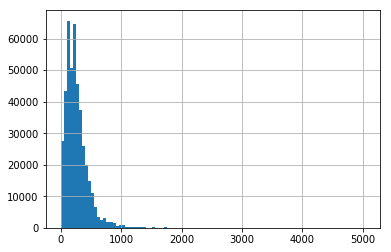

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = adf
df.len.hist(bins=100)
print(df.shape)

def seq2ngrams(seqs, n=3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs])

maxlen_seq = 128
input_seqs, target_seqs = df[['seq', 'sst3']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

Using TensorFlow backend.


((95891, 128), (95891, 128, 4))

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

W0629 07:17:16.184705 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0629 07:17:16.219809 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0629 07:17:16.227000 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



8421 4


W0629 07:17:16.396435 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0629 07:17:16.406652 139802754787200 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 4)            516       
Total params: 1,177,220
Trainable params: 1,177,220
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History 

loss = []
acc = []
val_loss = []
val_acc = []

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []

    def on_batch_end(self, batch, logs={}):
      loss.append(logs.get('loss'))
      acc.append(logs.get('acc'))
      val_acc.append(logs.get('val_acc'))
      val_loss.append(logs.get('val_loss'))
      return
    '''def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return'''

hist = History()
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q3_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


W0629 07:17:17.365664 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0629 07:17:17.389561 139802754787200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0629 07:17:17.427649 139802754787200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 234s 4ms/step - loss: 0.4021 - acc: 0.8319 - q3_acc: 0.7341 - val_loss: 0.3037 - val_acc: 0.8799 - val_q3_acc: 0.8091
Epoch 2/5
57534/57534 [==============================] - 227s 4ms/step - loss: 0.2842 - acc: 0.8880 - q3_acc: 0.8218 - val_loss: 0.2686 - val_acc: 0.8958 - val_q3_acc: 0.8344
Epoch 3/5
57534/57534 [==============================] - 225s 4ms/step - loss: 0.2507 - acc: 0.9024 - q3_acc: 0.8447 - val_loss: 0.2493 - val_acc: 0.9037 - val_q3_acc: 0.8468
Epoch 4/5
57534/57534 [==============================] - 236s 4ms/step - loss: 0.2290 - acc: 0.9112 - q3_acc: 0.8588 - val_loss: 0.2309 - val_acc: 0.9118 - val_q3_acc: 0.8598
Epoch 5/5
57534/57534 [==============================] - 253s 4ms/step - loss: 0.2112 - acc: 0.9185 - q3_acc: 0.8703 - val_loss: 0.2232 - val_acc: 0.9154 - val_q3_acc: 0.8655


In [ ]:
a = pd.DataFrame.from_dict(hist.history)
a.to_csv(r"lstmHistoryQ3.csv" , index = None, header=True)
a.head()
print (hist.history)

{'val_loss': [0.3081398104003371, 0.27128989968225403, 0.24854805617829162, 0.23112238222158132, 0.22036607067554287], 'val_acc': [0.8767628382663084, 0.8941011826549534, 0.9031838223605794, 0.9110199491572485, 0.9161119140543001], 'val_q3_acc': [0.8040916033493769, 0.8316469496005761, 0.846087391336963, 0.8585359902809792, 0.8666348060598885], 'loss': [0.4040375744421688, 0.2837368341806215, 0.2522511580466155, 0.2297866181568387, 0.21161658762559432], 'acc': [0.8305125827833564, 0.8876532517687208, 0.9011061665938628, 0.9103779939067423, 0.9177284029650068], 'q3_acc': [0.7307759775634552, 0.8213758073211292, 0.842703464701132, 0.8574797694698905, 0.8691583331365483]}


training
---
Input: IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDM
Target: CCCCCEEEEEECCCCCCCCCEEEEEEEEEECCCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC
Result: CCECCEEEEEECCCCCCCCCEEEEEEEEEEECCCCEEEEEECCEECCCCEECCCEECCCCCEEEEEEEEECCCCCCCEEEEEECCCCCCCEEEECCCCC


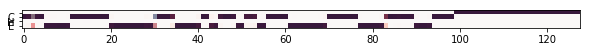

---
Input: EIDYKDIATLKNYITESGKIVPSRITGTRAKYQRQLARAIKRARYLSLLPYTDRH
Target: CCCCCCHHHHHCCECCCCCECCHHHHCCCHHHHHHHHHHHHHHHHCCCCCCCCCC
Result: CCCCCCHHHHHHCCCCCCCECCHHHHCCCHHHHHHHHHHHHHHHHCCCCCCCCCC


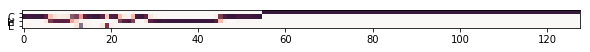

---
Input: MARLTAYERRKFRVRNRIKRTGRLRLSVFRSLKHIYAQIIDDEKGVTLVSASSLALKLKGNKTEVARQVGRALAEKALALGIKQVAFDRGPYKYHGRVKALAEGAREGGLEF
Target: CCCCCHHHHHHHHHHHHHHHCCCCEEEEEECCCCEEEEEEECCCCEEEEEEECCCCCCCCCHHHHHHHHHHHHHHHHHCCCCCECEEECCCCCCCHHHHHHHHHHHHHCCEC
Result: CCCCCCHHHHCCHCHHHHHCCCCCEEEEECCCCCEEEEEEECCCCEEEEECCCCCCCCCCCHHHHHHHHHHHHHHHHHHCCCCCCCCCCCCCCCCCCHHHHHCCCCCCCCCC


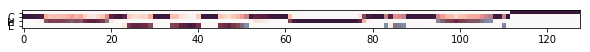

testing
---
Input: MIQPQTYLEVADNTGARKIMCIRVLKGSNAKYATVGDVIVASVKEAIPRGAVKEGDVVKAVVVRTKKEIKRPDGSAIRFDDNAAVIINNQLEPRGTRVFGPVARELREKGFMKIVSLAPEVL
Target: CECCCCEEEECECCCEEEEEEEEECCCCCCCCECCCCEEEEEEEEECCCCCCCCEEEEEEEEEECCCCEECCCCCEEEECCCEEEEECCCCCECCCCECCCECCHHHHHCCHHHHHHCCCEC
Result: CECCCCEEEECCCCCEEEEEEEEECCCCCCCCCCCCCEEEEEEEEECCCCCCCCCCEEEEEEEECCCCEECCCCCEEEECCCEEEEECCCCCECCCCCCCCECCHHHHHCCHHHHHHCCCEC


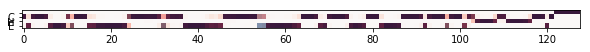

---
Input: GSHMGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEQITRTQEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE
Target: CCCCCCCCCCCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHCCCCHHHHHHHHCCCHHHHHCCEEEEECCCCCCHHHHHHHHHCCCCCECCCEEECCEEEEEEECC
Result: CCCCCCCCCCCCCCEEEEEEEECCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHCCCCCHHHHHHHHHHHHHHHCCCCEEEEECCCCCHHHHHHHHHCCCCCECCCEEECCCEEEEEEEC


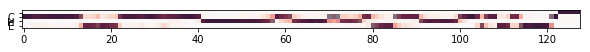

---
Input: MLIFVHIIAPVISGCAIAFFSYWLSRRNTK
Target: CHHHCCCCCCCHHHHHHHHHHHHHHHHCCC
Result: CEEEEEEEHHHHHHHHHHHHHHCCCCCCCC


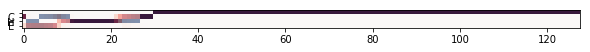

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

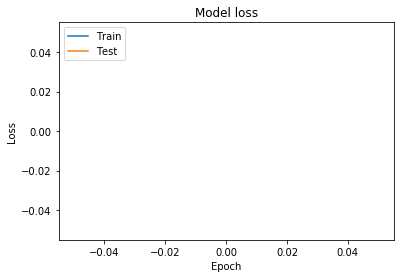

In [ ]:
f = plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("lstmTrainLossQ3.pdf", bbox_inches='tight')


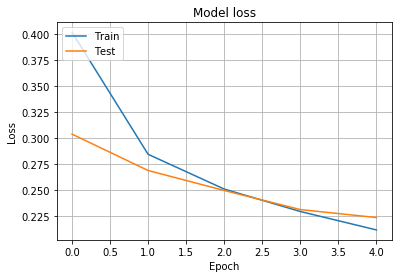

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("lstmModelLossQ3.pdf", bbox_inches='tight')

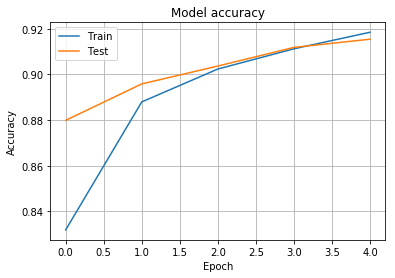

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("lstmModelAccuracyQ3.pdf", bbox_inches='tight')

In [ ]:
t = model.predict(X_test)
res = np.zeros((3,3))
tres = np.zeros((3,3))
def diff(a, b):
  res = np.zeros((3,3))
  x = str(onehot_to_seq(a, revsere_decoder_index).upper())
  y = str(onehot_to_seq(b, revsere_decoder_index).upper())
  for i in range(len(x)):
    if (x[i]==y[i] and x[i]=='C'):
      res[0][0]+=1
    if (x[i]!=y[i] and x[i]=='C' and y[i]=='E'):
      res[1][0]+=1
    if (x[i]!=y[i] and x[i]=='C' and y[i]=='H'):
      res[2][0]+=1
    if(x[i]==y[i] and x[i]=='E'):
      res[1][1]+=1
    if (x[i]!=y[i] and x[i]=='E'and y[i]=='C'):
      res[0][1]+=1
    if (x[i]!=y[i] and x[i]=='E'and y[i]=='H'):
      res[2][1]+=1
    if(x[i]==y[i] and x[i]=='H'):
      res[2][2]+=1
    if(x[i]!=y[i] and x[i]=='H'and y[i]=='C'):
      res[0][2]+=1
    if(x[i]!=y[i] and x[i]=='H'and y[i]=='E'):
      res[1][2]+=1
  return res

for i in range(38357):
  tres=diff(t[i], y_test[i])
  res +=tres

TypeError: ignored

TypeError: ignored

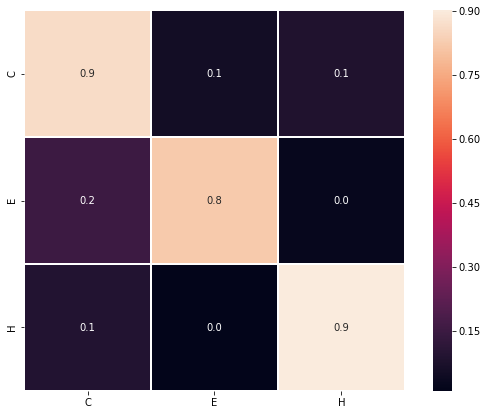

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf = np.zeros((3,3))
for i in range(3):
  for j in range(3):
    conf[i][j] = res[i][j]/(res[i].sum())
print(conf)

df_cm = pd.DataFrame(conf, index = [i for i in "CEH"],
                  columns = [i for i in "CEH"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt = '.1f', square=1, linewidth=1.)


In [ ]:
#different size of lstm on Q3

from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

l=[25,50,100,150,200,250]

for i in l:
  X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
  seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)


  n_words = len(tokenizer_encoder.word_index) + 1
  n_tags = len(tokenizer_decoder.word_index) + 1
  print(n_words, n_tags)

  input = Input(shape=(maxlen_seq,))
  x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
  x = Bidirectional(LSTM(units=i, return_sequences=True, recurrent_dropout=0.1))(x)
  y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
  model = Model(input, y)
  model.summary()

  loss = []
  acc = []
  val_loss = []
  val_acc = []

  def q3_acc(y_true, y_pred):
      y = tf.argmax(y_true, axis=-1)
      y_ = tf.argmax(y_pred, axis=-1)
      mask = tf.greater(y, 0)
      return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())



  model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q3_acc])

  hist = History()

  history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


8421 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128, 50)           30800     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 128, 4)            204       
Total params: 1,108,892
Trainable params: 1,108,892
Non-trainable params: 0
_________________________________________________________________
Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 247s 4ms/step - loss: 0.4259 - acc: 0.8256 - q3_acc: 0.7242 - val_loss: 0.3147 - val_acc: 0.8748 - val_q3_acc: 0.8010
Epoch 2/5
57534/57534 [=========

check for sst8

In [ ]:
input_seqs, target_seqs = df[['seq', 'sst8']][(df.len <= maxlen_seq) & (~df.has_nonstd_aa)].values.T
input_grams = seq2ngrams(input_seqs)
print(len(input_seqs))

95891


In [ ]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

tokenizer_encoder = Tokenizer()
tokenizer_encoder.fit_on_texts(input_grams)
input_data = tokenizer_encoder.texts_to_sequences(input_grams)
input_data = sequence.pad_sequences(input_data, maxlen=maxlen_seq, padding='post')

tokenizer_decoder = Tokenizer(char_level=True)
tokenizer_decoder.fit_on_texts(target_seqs)
target_data = tokenizer_decoder.texts_to_sequences(target_seqs)
target_data = sequence.pad_sequences(target_data, maxlen=maxlen_seq, padding='post')
target_data = to_categorical(target_data)
input_data.shape, target_data.shape

((95891, 128), (95891, 128, 9))

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(tokenizer_encoder.word_index) + 1
n_tags = len(tokenizer_decoder.word_index) + 1
print(n_words, n_tags)

input = Input(shape=(maxlen_seq,))
x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
x = Bidirectional(LSTM(units=64, return_sequences=True, recurrent_dropout=0.1))(x)
y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
model = Model(input, y)
model.summary()

8421 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 128)          1077888   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 128)          98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 128, 9)            1161      
Total params: 1,177,865
Trainable params: 1,177,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History 

loss = []
acc = []
val_loss = []
val_acc = []

def q8_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self._data = []
    def on_batch_end(self, batch, logs={}):
      loss.append(logs.get('loss'))
      acc.append(logs.get('acc'))
      val_acc.append(logs.get('val_acc'))
      val_loss.append(logs.get('val_loss'))
      return
    '''def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        y_predict = np.asarray(model.predict(X_val))

        y_val = np.argmax(y_val, axis=1)
        y_predict = np.argmax(y_predict, axis=1)

        self._data.append({
            'val_recall': recall_score(y_val, y_predict),
            'val_precision': precision_score(y_val, y_predict),
        })
        return'''

hist = History()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q8_acc])

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)

history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])


Train on 57534 samples, validate on 38357 samples
Epoch 1/5
57534/57534 [==============================] - 255s 4ms/step - loss: 0.7263 - acc: 0.7456 - q8_acc: 0.5963 - val_loss: 0.5663 - val_acc: 0.8051 - val_q8_acc: 0.6903
Epoch 2/5
57534/57534 [==============================] - 255s 4ms/step - loss: 0.5227 - acc: 0.8225 - q8_acc: 0.7177 - val_loss: 0.4904 - val_acc: 0.8360 - val_q8_acc: 0.7393
Epoch 3/5
57534/57534 [==============================] - 251s 4ms/step - loss: 0.4651 - acc: 0.8431 - q8_acc: 0.7505 - val_loss: 0.4555 - val_acc: 0.8482 - val_q8_acc: 0.7586
Epoch 4/5
57534/57534 [==============================] - 256s 4ms/step - loss: 0.4288 - acc: 0.8556 - q8_acc: 0.7703 - val_loss: 0.4267 - val_acc: 0.8580 - val_q8_acc: 0.7742
Epoch 5/5
57534/57534 [==============================] - 229s 4ms/step - loss: 0.4017 - acc: 0.8646 - q8_acc: 0.7847 - val_loss: 0.4129 - val_acc: 0.8636 - val_q8_acc: 0.7832


In [ ]:
a = pd.DataFrame.from_dict(hist.history)
a.to_csv(r"lstmHistoryQ8.csv" , index = None, header=True)
a.head()

,val_loss,val_acc,val_q8_acc,loss,acc,q8_acc
0,0.566286,0.805138,0.690270,0.726251,0.745552,0.596261
1,0.490403,0.835981,0.739270,0.522660,0.822499,0.717705
2,0.455523,0.848160,0.758619,0.465096,0.843136,0.750502
3,0.426708,0.857990,0.774241,0.428799,0.855567,0.770288
4,0.412923,0.863596,0.783153,0.401659,0.864599,0.784665


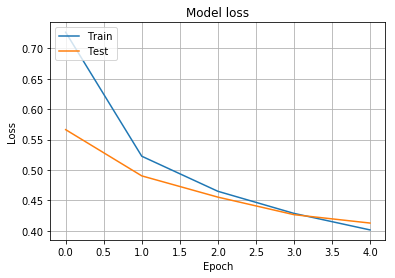

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("lstmModelLossQ8.pdf", bbox_inches='tight')

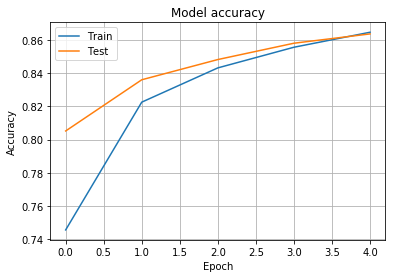

In [ ]:
f = plt.figure()
plt.grid()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
f.savefig("lstmModelAccuracyQ8.pdf", bbox_inches='tight')

In [ ]:
#t = model.predict(X_test)
res = np.zeros((8,8))
tres = np.zeros((8,8))
def diff(a, b):
  res = np.zeros((8,8))
  x = str(onehot_to_seq(a, revsere_decoder_index).upper())
  y = str(onehot_to_seq(b, revsere_decoder_index).upper())
  for i in range(len(x)):
    if (x[i]==y[i] and x[i]=='B'):
      res[0][0]+=1
    if(x[i]=='B' and y[i]=='C'):
      res[0][1]+=1
    if(x[i]=='B' and y[i]=='E'):
      res[0][2]+=1
    if(x[i]=='B' and y[i]=='G'):
      res[0][3]+=1
    if(x[i]=='B' and y[i]=='H'):
      res[0][4]+=1
    if(x[i]=='B' and y[i]=='I'):
      res[0][5]+=1
    if(x[i]=='B' and y[i]=='S'):
      res[0][6]+=1
    if(x[i]=='B' and y[i]=='T'):
      res[0][7]+=1
    
    if (x[i]==y[i] and x[i]=='C'):
      res[1][1]+=1
    if(x[i]=='C' and y[i]=='B'):
      res[1][0]+=1
    if(x[i]=='C' and y[i]=='E'):
      res[1][2]+=1
    if(x[i]=='C' and y[i]=='G'):
      res[1][3]+=1
    if(x[i]=='C' and y[i]=='H'):
      res[1][4]+=1
    if(x[i]=='C' and y[i]=='I'):
      res[1][5]+=1
    if(x[i]=='C' and y[i]=='S'):
      res[1][6]+=1
    if(x[i]=='C' and y[i]=='T'):
      res[1][7]+=1
    
    if (x[i]==y[i] and x[i]=='E'):
      res[2][2]+=1
    if(x[i]=='E' and y[i]=='B'):
      res[2][0]+=1
    if(x[i]=='E' and y[i]=='C'):
      res[2][1]+=1
    if(x[i]=='E' and y[i]=='G'):
      res[2][3]+=1
    if(x[i]=='E' and y[i]=='H'):
      res[2][4]+=1
    if(x[i]=='E' and y[i]=='I'):
      res[2][5]+=1
    if(x[i]=='E' and y[i]=='S'):
      res[2][6]+=1
    if(x[i]=='E' and y[i]=='T'):
      res[2][7]+=1
      
    if (x[i]==y[i] and x[i]=='G'):
      res[3][3]+=1
    if(x[i]=='G' and y[i]=='B'):
      res[3][0]+=1
    if(x[i]=='G' and y[i]=='C'):
      res[3][1]+=1
    if(x[i]=='G' and y[i]=='E'):
      res[3][2]+=1
    if(x[i]=='G' and y[i]=='H'):
      res[3][4]+=1
    if(x[i]=='G' and y[i]=='I'):
      res[3][5]+=1
    if(x[i]=='G' and y[i]=='S'):
      res[3][6]+=1
    if(x[i]=='G' and y[i]=='T'):
      res[3][7]+=1
     
    if (x[i]==y[i] and x[i]=='H'):
      res[4][4]+=1
    if(x[i]=='H' and y[i]=='B'):
      res[4][0]+=1
    if(x[i]=='H' and y[i]=='C'):
      res[4][1]+=1
    if(x[i]=='H' and y[i]=='E'):
      res[4][2]+=1
    if(x[i]=='H' and y[i]=='G'):
      res[4][3]+=1
    if(x[i]=='H' and y[i]=='I'):
      res[4][5]+=1
    if(x[i]=='H' and y[i]=='S'):
      res[4][6]+=1
    if(x[i]=='H' and y[i]=='T'):
      res[4][7]+=1
     
    if (x[i]==y[i] and x[i]=='I'):
      res[5][5]+=1
    if(x[i]=='I' and y[i]=='B'):
      res[5][0]+=1
    if(x[i]=='I' and y[i]=='C'):
      res[5][1]+=1
    if(x[i]=='I' and y[i]=='E'):
      res[5][2]+=1
    if(x[i]=='I' and y[i]=='G'):
      res[5][3]+=1
    if(x[i]=='I' and y[i]=='H'):
      res[5][4]+=1
    if(x[i]=='I' and y[i]=='S'):
      res[5][6]+=1
    if(x[i]=='I' and y[i]=='T'):
      res[5][7]+=1
      
    if (x[i]==y[i] and x[i]=='S'):
      res[6][6]+=1
    if(x[i]=='S' and y[i]=='B'):
      res[6][0]+=1
    if(x[i]=='S' and y[i]=='C'):
      res[6][1]+=1
    if(x[i]=='S' and y[i]=='E'):
      res[6][2]+=1
    if(x[i]=='S' and y[i]=='G'):
      res[6][3]+=1
    if(x[i]=='S' and y[i]=='H'):
      res[6][4]+=1
    if(x[i]=='S' and y[i]=='I'):
      res[6][5]+=1
    if(x[i]=='S' and y[i]=='T'):
      res[6][7]+=1
      
    if (x[i]==y[i] and x[i]=='T'):
      res[7][7]+=1
    if(x[i]=='T' and y[i]=='B'):
      res[7][0]+=1
    if(x[i]=='T' and y[i]=='C'):
      res[7][1]+=1
    if(x[i]=='T' and y[i]=='E'):
      res[7][2]+=1
    if(x[i]=='T' and y[i]=='G'):
      res[7][3]+=1
    if(x[i]=='T' and y[i]=='H'):
      res[7][4]+=1
    if(x[i]=='T' and y[i]=='I'):
      res[7][5]+=1
    if(x[i]=='T' and y[i]=='S'):
      res[7][6]+=1
    
  return res

for i in range(38357):
  tres=diff(t[i], y_test[i])
  res +=tres

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


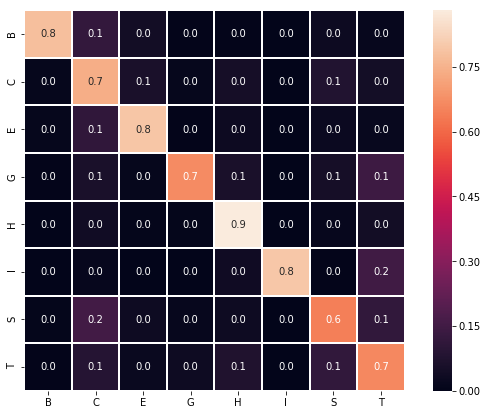

In [ ]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf = np.zeros((8,8))
for i in range(8):
  for j in range(8):
    conf[i][j] = res[i][j]/(res[i].sum())


df_cm = pd.DataFrame(conf, index = [i for i in "BCEGHIST"],
                  columns = [i for i in "BCEGHIST"])
plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, fmt = '.1f', square=1, linewidth=1.)

In [ ]:
print(a)

[[37732     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0]
 [    6    71     8     9     2    10     3     2     4]
 [    6    21     3     1     0     2     3     1     0]
 [    5    33     0     1     1     2     2     4    10]
 [    2    13     0     2     4    15     0     3     3]
 [   12   212     3    18    12    27    13    12     0]
 [    4    44     2     4     1     6     3     0     0]
 [    0     0     0     0     0     0     0     0     0]]


training
---
Input: IQKTPQIQVYSRHPPENGKPNILNCYVTQFHPPHIEIQMLKNGKKIPKVEMSDMSFSKDWSFYILAHTEFTPTETDTYACRVKHASMAEPKTVYWDRDM
Target: CCCCCEEEEEESSCCCSSSCEEEEEEEEEESSSCCEEEEEETTEECSSCEECCCEECTTSCEEEEEEEEECCCSSCCEEEEEECSSCSSCEEEECCSCC
Result: CCBCCEEEEEESSCCCTTSCEEEEEEEEEEBSSCCEEEEEETTEECSCCEECCCEECTTSCEEEEEEEEECCCSSCCEEEEEECTTCSSCEEEECCTTC


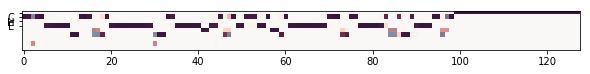

---
Input: EIDYKDIATLKNYITESGKIVPSRITGTRAKYQRQLARAIKRARYLSLLPYTDRH
Target: CCCSSCHHHHHTTBCTTSCBCCHHHHCCCHHHHHHHHHHHHHHHHTTSSCSCSCC
Result: CCCSSCHHHHHGSBCTTSCCCCHHHHCCCHHHHHHHHHHHHHHHHTTSSCSSSCC


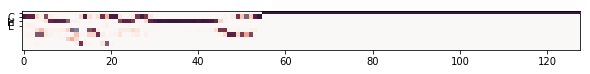

---
Input: MARLTAYERRKFRVRNRIKRTGRLRLSVFRSLKHIYAQIIDDEKGVTLVSASSLALKLKGNKTEVARQVGRALAEKALALGIKQVAFDRGPYKYHGRVKALAEGAREGGLEF
Target: CCCCCHHHHHHHHHHHHHHHTTCCEEEEEECSSCEEEEEEETTTTEEEEEEETTTTTCCSCHHHHHHHHHHHHHHHHHTTTCCBCEEECTTSCSCHHHHHHHHHHHHHTCBC
Result: CCCCCCCCCCCCCCCCGCCCSSSCEEEEECCSSCEEEEEEETTTTEEEEECCSTTTCCCSCSHHHHHHHHHHHHHHHHTTTCCCCCCCCTTCCSSSCCCCCCSSCCCCCCCC


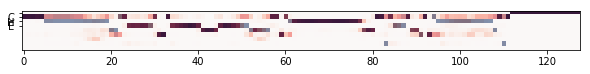

testing
---
Input: MIQPQTYLEVADNTGARKIMCIRVLKGSNAKYATVGDVIVASVKEAIPRGAVKEGDVVKAVVVRTKKEIKRPDGSAIRFDDNAAVIINNQLEPRGTRVFGPVARELREKGFMKIVSLAPEVL
Target: CBCTTCEEEECBSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECTTCSSCSEEEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTCCBSSSCBCSCBCTHHHHHTCHHHHHHCSCBC
Result: CBCTTCEEEECSSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECTTSSSCTTCEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTSCBSSSCBCSCBCTHHHHTTCHHHHHHSSCBC


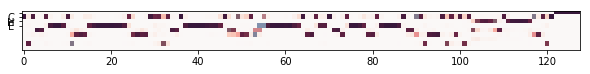

---
Input: GSHMGKNGQGEPARVRCSHLLVKHSQSRRPSSWRQEQITRTQEEALELINGYIQKIKSGEEDFESLASQFSDCSSAKARGDLGAFSRGQMQKPFEDASFALRTGEMSGPVFTDSGIHIILRTE
Target: CCCCCCCCCCCCSCEEEEEEEECCTTSSSCCCSSCSSCCCCHHHHHHHHHHHHHHHHHTSSCHHHHHHHHCSSGGGGGTTEEEEECTTSSCHHHHHHHHHSCTTCBCCCEEETTEEEEEEECC
Result: CCCCCCCCCCCCCCEEEEEEEECCTTSSCCCCSCCSSCCCCHHHHHHHHHHHHHHHHTSSCHHHHHHHHHGGGGGGGGTTEEEEEETCSSSSHHHHHHHHHTTTCCCCCEEETTEEEEEEEEC


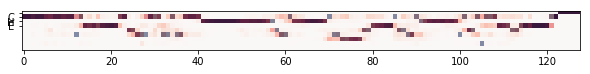

---
Input: MLIFVHIIAPVISGCAIAFFSYWLSRRNTK
Target: CGGGTSSTTTTHHHHHHHHHHHHHHHHSCC
Result: CEEEEEEEEGEHHHHHHHHHHHHCCCCCCC


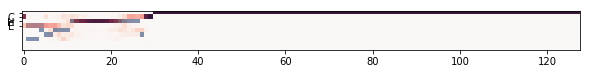

In [ ]:
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

def plot_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
    fig = plt.figure(figsize=(10,2))
    plt.imshow(y.T, cmap='Blues')
    plt.imshow(y_.T, cmap='Reds', alpha=.5)
    plt.yticks(range(4), [' '] + [revsere_decoder_index[i+1].upper() for i in range(3)])
    plt.show()
    
revsere_decoder_index = {value:key for key,value in tokenizer_decoder.word_index.items()}
revsere_encoder_index = {value:key for key,value in tokenizer_encoder.word_index.items()}

N=3
y_train_pred = model.predict(X_train[:N])
y_test_pred = model.predict(X_test[:N])
print('training')
for i in range(N):
    plot_results(seq_train[i], y_train[i], y_train_pred[i])
print('testing')
for i in range(N):
    plot_results(seq_test[i], y_test[i], y_test_pred[i])

In [ ]:
def plotiii_results(x, y, y_):
    print("---")
    print("Input: " + str(x))
    print("Target: " + str(onehot_to_seq(y, revsere_decoder_index).upper()))
    print("Result: " + str(onehot_to_seq(y_, revsere_decoder_index).upper()))
y_train_pred = model.predict(X_test[:20])
y_test_pred = model.predict(X_test[:20])

print('testing')
for i in range(20):
    plotiii_results(X_test[i], y_test[i], y_test_pred[i])

testing
---
Input: [1521 4788 4592 2885 4548 2728 1840  148  302 1157 1842 3723 1967  253
  881  309 1206 3430 6622 5730 5065 1382  426   33  362  954 1104 1328
  713 2044 2617 2860  410 1091  573  305 1175  560  532  714  169  399
  210   21  731 2652 1606 1246  643  604  559  210  196  830  305  400
  219   83   81  223  198  678 2844 1083  534  375  208  272  416  550
 2130  958  634  727  686  660 3574 2502 2763 4079 1734  301  207  729
 1764 1854 2026 3958 1009   92 1359 4160 1246  723 1300  651 1968 1730
 3329 1975 2326  432  245   89   47  103 1082  615 2242 5512 4261 3185
  165 1244  893  240 1715 1712 2273   24 3889   22    0    0    0    0
    0    0]
Target: CBCTTCEEEECBSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECTTCSSCSEEEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTCCBSSSCBCSCBCTHHHHHTCHHHHHHCSCBC
Result: CBCTTCEEEECBSSSEEEEEEEEECSSSSCCCBCTTCEEEEEEEEECSSCSSCTTCEEEEEEEECSSCEECTTSCEEEESSCEEEEECTTSCBSSSCBCSCBCTHHHHHTCHHHHHHSSCBC
---
Input: [  54  357 5187 2764 1997   86 1387  799 2561 3699 3236 2

In [ ]:
#different size of lstm on Q8

from sklearn.model_selection import train_test_split
from keras.metrics import categorical_accuracy
from keras import backend  as K
import tensorflow as tf
import keras
from keras.callbacks import History
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional,GRU

l=[25,50,100,150,200,250]

for i in l:
  X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=.4, random_state=0)
  seq_train, seq_test, target_train, target_test = train_test_split(input_seqs, target_seqs, test_size=.4, random_state=0)


  n_words = len(tokenizer_encoder.word_index) + 1
  n_tags = len(tokenizer_decoder.word_index) + 1
  print(n_words, n_tags)

  input = Input(shape=(maxlen_seq,))
  x = Embedding(input_dim=n_words, output_dim=128, input_length=maxlen_seq)(input)
  x = Bidirectional(LSTM(units=i, return_sequences=True, recurrent_dropout=0.1))(x)
  y = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
  model = Model(input, y)
  model.summary()

  loss = []
  acc = []
  val_loss = []
  val_acc = []

  def q8_acc(y_true, y_pred):
      y = tf.argmax(y_true, axis=-1)
      y_ = tf.argmax(y_pred, axis=-1)
      mask = tf.greater(y, 0)
      return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())



  model.compile(optimizer="rmsprop", loss="categorical_crossentropy",  metrics=["accuracy", q8_acc])

  hist = History()

  history = model.fit(X_train, y_train, batch_size=128, epochs=5,steps_per_epoch=None, validation_steps=None, validation_data=(X_test, y_test), verbose=1, callbacks=[hist])
